In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
usecols = ['AGE', 'ANL_INCM', 'ANVRSRY_DATE','BIRTH_DATE','COMNCTN_IND', 'CORPRT_CD', 'Enquiry Customer Type', 'Enquiry Source',
 'Enquiry Date', 'Enquiry Type','link_Enquiry', 'link_Model', 'LOCTN_CD', 'MARTL_IND', 'MOTHER_TONGE', 'No Of Followup',
 'Occupation Desc', 'PARNT_GROP', 'PERMNT_PIN', 'Procrurement Offer Responce', 'RELGN_CD', 'RES_PIN', 'SEX_IND',
 'SORC_CD', 'Web Enquiry Flag', 'LEAD_TYPE']
parse_dates = ['ANVRSRY_DATE', 'Enquiry Date']
dtype_dict = {'AGE': 'Int8', 'ANL_INCM': 'category', 'ANVRSRY_DATE': 'str','BIRTH_DATE':'str', 'COMNCTN_IND': 'category', 'CORPRT_CD': 'category',
 'Enquiry Customer Type': 'category', 'Enquiry Source': 'category', 'Enquiry Date': 'str', 'Enquiry Type': 'category','link_Enquiry':'float64',
 'link_Model': 'object', 'LOCTN_CD': 'object', 'MARTL_IND': 'category', 'MOTHER_TONGE': 'Int8', 'No Of Followup': 'Int16',
 'Occupation Desc': 'category', 'PARNT_GROP': 'object', 'PERMNT_PIN': 'Int32', 'Procrurement Offer Responce': 'category',
 'RELGN_CD': 'category', 'RES_PIN': 'Int32', 'SEX_IND': 'category', 'SORC_CD': 'category', 'Web Enquiry Flag': 'category',
 'LEAD_TYPE': 'category'}

In [203]:

def load_Enq():
    enq = pd.read_csv("Enquiry new data.csv",
                  usecols= usecols,
#                   dtype=dtype_dict,
                  parse_dates=parse_dates,
                  nrows=300000,
                  error_bad_lines=False,
#                   na_filter=False,
                  engine='c',
                  low_memory=False)

#     csv_path=pd.read_csv("Enquiry new data.csv", encoding="Cp1252", low_memory=False,nrows=100000)
    return enq

In [204]:
def load_retail():
    csv_path=pd.read_csv("retail.csv", encoding="Cp1252", low_memory=False)
    return csv_path

In [205]:
retail=load_retail()

In [206]:
enq=load_Enq()

In [207]:
retail.rename(columns= {'Invoice Status':'Invoice_Status'}, inplace=True)

In [208]:
#to check if enquiry is present in retail table (Y lable)
def checkInRetail(row):
    if row["link_Enquiry_enq"]==row["link_Enquiry"]:
        return 1
    else:
        return 0
    

In [209]:
enq["ANVRSRY_DATE"]=pd.to_datetime(enq["ANVRSRY_DATE"], errors = 'coerce')
enq["Enquiry Date"]=pd.to_datetime(enq["Enquiry Date"])
enq["BIRTH_DATE"]=pd.to_datetime(enq["BIRTH_DATE"])

In [210]:
# to check if enquiry was made near birth/anniversary date
def anniversaryVsBirthVsEnquiryDate(row):
    
#(enq["BIRTH_DATE"]-enq["Enquiry Date"]).astype('<m8[M]')
   return (1 if (abs(row["BIRTH_DATE"].month - row["Enquiry Date"].month)<=1 or \
           abs(row["ANVRSRY_DATE"].month - row["Enquiry Date"].month)<=1) else 0)
        
        
enq["celebration"]=enq.apply(anniversaryVsBirthVsEnquiryDate,axis=1)



In [211]:
enq.dropna(subset=['ANL_INCM'],inplace=True)

In [212]:
enq['celebration'].value_counts()

0    119707
1     61739
Name: celebration, dtype: int64

In [213]:
enq["BIRTH_DATE"].dt.month - enq["Enquiry Date"].dt.month

0         0
1        -8
2        -4
3         4
4         4
5         4
6         4
7        -4
8        -4
9        -1
10        5
11       -2
12        0
13       -6
14       -6
15       -6
16       -6
17        0
18       -2
19       -2
20        2
21        2
22        6
23        2
24        2
25        0
26       -2
27       -3
28        5
29       -4
         ..
299970   -7
299971   -9
299972   -2
299973   -1
299974    2
299975    2
299976   -4
299977   -3
299978   -3
299979   -6
299980   -6
299981   -4
299982   -5
299983    0
299984    0
299985    0
299986    0
299987    0
299988    0
299989    0
299990    0
299991    0
299992    0
299993    0
299994    0
299995    0
299996    0
299997    0
299998    0
299999    0
Length: 181446, dtype: int64

In [14]:
# retail.dropna(subset=['link_Enquiry'],inplace=True)

In [214]:
enq.rename(columns={"link_Enquiry":"link_Enquiry_enq"}, inplace=True)
# retail=retail.query("Invoice_Type=='CI' and Invoice_Status=='Invoiced'")
enq=pd.merge(enq,retail.link_Enquiry.to_frame(),left_on=["link_Enquiry_enq"], right_on=["link_Enquiry"],how="left")


In [16]:
# enq.drop_duplicates(inplace=True)

In [17]:
enq

,AGE,ANL_INCM,ANVRSRY_DATE,BIRTH_DATE,COMNCTN_IND,CORPRT_CD,Enquiry Customer Type,Enquiry Date,Enquiry Source,Enquiry Type,...,PERMNT_PIN,Procrurement Offer Responce,RELGN_CD,RES_PIN,SEX_IND,SORC_CD,Web Enquiry Flag,LEAD_TYPE,celebration,link_Enquiry
0,1.0,A2,2018-05-15,2017-06-15,OFC,9999.0,Corporate,2018-06-30,Newspaper,Walk-in,...,NaN,Rejected,H,NaN,M,NWP,Non-CW,WLK,1,51099833.0
1,1.0,A2,NaT,2017-01-07,PRM,NaN,Individual,2018-09-20,DSA / DMA,Field,...,695542.0,Rejected,H,695542.0,M,DSA,Non-CW,FLD,0,52313381.0
2,1.0,A2,NaT,2017-01-07,PRM,NaN,Individual,2018-09-20,DSA / DMA,Field,...,695542.0,Rejected,H,695542.0,M,DSA,Non-CW,FLD,0,52313381.0
3,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-10-02,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49257332.0
4,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0
5,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0
6,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0
7,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0
8,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0
9,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,...,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0


In [215]:
enq["result"]=enq.apply(checkInRetail,axis=1)

In [216]:
enq["models"]=enq["link_Model"].str[:4]
enq["result"].value_counts()

0    120582
1     67830
Name: result, dtype: int64

In [219]:
# to impute null fields of AGE column
mean=enq["AGE"].mean()
std=enq["AGE"].std()

is_null = (~enq["AGE"].notnull()).sum()
# compute random numbers between the mean, std and is_null
rand_age=np.random.randint(mean-std,mean+std,size=is_null)
age_slice=enq["AGE"].copy()
age_slice[~enq.AGE.notnull()]=rand_age
# print(rand_age)
# break
enq["AGE"]=age_slice

In [220]:
finalEnq=enq.drop(columns=['ANVRSRY_DATE','BIRTH_DATE','CORPRT_CD','link_Model','PARNT_GROP','PERMNT_PIN','RES_PIN','link_Enquiry_enq','link_Enquiry',"Procrurement Offer Responce","Web Enquiry Flag",'LEAD_TYPE'],axis=1)

In [221]:
names=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90>']
bins=[0,10,20,30,40,50,60,70,80,90]
d = dict(enumerate(names, 1))

finalEnq['AgeRange'] = np.vectorize(d.get)(np.digitize(finalEnq['AGE'], bins))

In [222]:
finalEnq["AgeRange"]=finalEnq["AgeRange"].astype('category')
finalEnq.drop('AGE',axis=1,inplace=True)

In [223]:
finalEnq['month']=finalEnq['Enquiry Date'].dt.month
finalEnq['day_of_week']=finalEnq['Enquiry Date'].dt.weekday_name

In [237]:
finalEnq.drop('Enquiry Date',inplace=True,axis=1)

In [240]:
# Function to draw conditional distribution plot splot by whether the customer subscribed
def draw_conditional_distplot(feature,df):
    # Seat seaborn to use nice colors
#     sns.set(palette=five_thirty_eight)
    # Draw the no plot
    sns.distplot(df[df.result == 0][feature],label='no')
    # Draw the yes plot
    sns.distplot(df[df.result == 1][feature],label='yes')
    # Draw the legend
    plt.legend()
    # Display the plot
    plt.show()

In [160]:
finalEnq['Enquiry Source'][0]

'Newspaper'

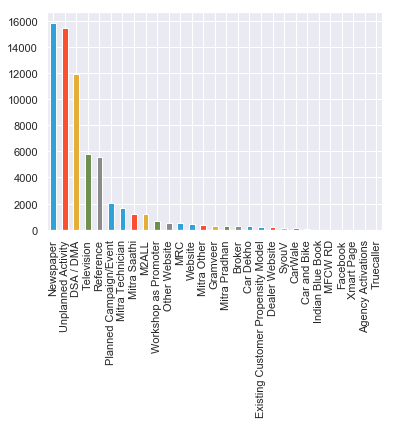

In [161]:
finalEnq[finalEnq.result == 0]['Enquiry Source'].value_counts().plot(kind='bar')

In [162]:
# finalEnq["Enquiry Source"]=finalEnq["Enquiry Source"].astype('str')

# draw_conditional_distplot('Enquiry Source',finalEnq)

In [163]:
draw_conditional_distplot(feature,df)

NameError: name 'feature' is not defined

In [165]:
# finalEnq['day_of_week']=finalEnq['BIRTH_DATE'].dt.weekday_name.value_counts().plot(kind='bar')

In [236]:
finalEnq

,ANL_INCM,COMNCTN_IND,Enquiry Customer Type,Enquiry Date,Enquiry Source,Enquiry Type,LOCTN_CD,MARTL_IND,MOTHER_TONGE,No Of Followup,Occupation Desc,RELGN_CD,SEX_IND,SORC_CD,celebration,result,models,AgeRange,month,day_of_week
0,A2,OFC,Corporate,2018-06-30,Newspaper,Walk-in,MK01,M,2.0,2,Salaried-Others,H,M,NWP,1,1,JETO,0-10,6,Saturday
1,A2,PRM,Individual,2018-09-20,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,H,M,DSA,0,1,MRZO,0-10,9,Thursday
2,A2,PRM,Individual,2018-09-20,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,H,M,DSA,0,1,MRZO,0-10,9,Thursday
3,A3,RES,Corporate,2018-10-02,Newspaper,Walk-in,AR02,M,2.0,2,Business,H,M,NWP,0,1,BOLP,0-10,10,Tuesday
4,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday
5,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday
6,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday
7,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday
8,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday
9,A3,RES,Corporate,2018-02-13,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,1,BOLP,0-10,2,Tuesday


In [24]:
# # Create old people group
# finalEnq['age_old'] = np.where(finalEnq['AGE'] >= 60, 1,0)
# # Create mid age people group
# finalEnq['age_mid'] = np.where((finalEnq['AGE'] <= 60) & (finalEnq['AGE'] >= 35), 1,0)
# # Create young people group
# finalEnq['age_young'] = np.where(finalEnq['AGE'] <= 35, 1,0)

In [241]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["LOCTN_CD"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["LOCTN_CD"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['LOCTN_CD'].isin(filterLocn)].index, axis=0,inplace=True)

In [242]:
#removing models having less than or equal to 5 occurences  in the data set
mod = pd.DataFrame(enq["models"].value_counts()<=5)
# lc.reset_index(inplace=True)
filterMod=mod[mod["models"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['models'].isin(filterMod)].index, axis=0,inplace=True)

In [243]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["Enquiry Source"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["Enquiry Source"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['Enquiry Source'].isin(filterLocn)].index, axis=0,inplace=True)

In [244]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["No Of Followup"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["No Of Followup"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['No Of Followup'].isin(filterLocn)].index, axis=0,inplace=True)

In [245]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["SORC_CD"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["SORC_CD"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['SORC_CD'].isin(filterLocn)].index, axis=0,inplace=True)

In [246]:
finalEnq["models"]=finalEnq["models"].astype('category')
finalEnq["LOCTN_CD"]=finalEnq["LOCTN_CD"].astype('category')

In [247]:
# finalEnq.drop("Enquiry Date",axis=1,inplace=True)

In [248]:
# This function fills null values with highest value in the column
finalEnq = finalEnq.apply(lambda x: x.fillna(x.value_counts().index[0]))


In [319]:
from sklearn import preprocessing
#Convert all the columns to string
finalEnq1=finalEnq.drop('result',axis=1)
input_x = finalEnq1.applymap(str)
# input_x_test=x_test.applymap(str)
input_x.dtypes.sort_index()

ANL_INCM                 object
AgeRange                 object
COMNCTN_IND              object
Enquiry Customer Type    object
Enquiry Source           object
Enquiry Type             object
LOCTN_CD                 object
MARTL_IND                object
MOTHER_TONGE             object
No Of Followup           object
Occupation Desc          object
RELGN_CD                 object
SEX_IND                  object
SORC_CD                  object
celebration              object
day_of_week              object
models                   object
month                    object
dtype: object

In [323]:
finalEnq1

,ANL_INCM,COMNCTN_IND,Enquiry Customer Type,Enquiry Source,Enquiry Type,LOCTN_CD,MARTL_IND,MOTHER_TONGE,No Of Followup,Occupation Desc,RELGN_CD,SEX_IND,SORC_CD,celebration,models,AgeRange,month,day_of_week
0,A2,OFC,Corporate,Newspaper,Walk-in,MK01,M,2.0,2,Salaried-Others,H,M,NWP,1,JETO,0-10,6,Saturday
1,A2,PRM,Individual,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,H,M,DSA,0,MRZO,0-10,9,Thursday
2,A2,PRM,Individual,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,H,M,DSA,0,MRZO,0-10,9,Thursday
3,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,2,Business,H,M,NWP,0,BOLP,0-10,10,Tuesday
4,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday
5,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday
6,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday
7,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday
8,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday
9,A3,RES,Corporate,Newspaper,Walk-in,AR02,M,2.0,3,Business,H,M,NWP,0,BOLP,0-10,2,Tuesday


In [250]:
input_x_array = np.array(input_x)
# input_x_test_array=np.array(input_x_test)

for i in range(input_x_array.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(input_x_array[:,i]))
    input_x_array[:, i] = lbl.transform(input_x_array[:, i])

In [320]:
finalEnq.columns

Index(['ANL_INCM', 'COMNCTN_IND', 'Enquiry Customer Type', 'Enquiry Source',
       'Enquiry Type', 'LOCTN_CD', 'MARTL_IND', 'MOTHER_TONGE',
       'No Of Followup', 'Occupation Desc', 'RELGN_CD', 'SEX_IND', 'SORC_CD',
       'celebration', 'result', 'models', 'AgeRange', 'month', 'day_of_week'],
      dtype='object')

In [324]:
finalEnq.shape

(188145, 19)

In [139]:
# input_array,lbl1=input_array(input_x_array)

In [140]:
# list(input_x_array[:,5])

In [141]:
# for i in range(input_x_array.shape[1]):
#     lbl = preprocessing.LabelEncoder()
#     lbl.fit(list(input_x_array[:,i]))
#     input_x_array[:, i] = lbl.transform(input_x_array[:, i])

In [253]:
x_train, x_test, y_train, y_test = train_test_split(input_x_array, finalEnq['result'].values, test_size=0.3,random_state=42)

In [274]:
x_=pd.DataFrame(x_train)

In [255]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, x_train, y_train, cv=3)
forest_scores.mean()

0.8002444896682616

In [256]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [257]:
y_pred_forest=forest.predict(x_test)
forest.score(x_test,y_test)

0.8101126780525831

In [258]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred_forest)

0.8101126780525831

In [271]:
y_pred_forest

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [259]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred_forest)

0.8101126780525831

In [260]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred_forest)

0.8014770309175115

In [261]:
recall_score(y_test, y_pred_forest)

0.6292256289308176

In [262]:
from sklearn.metrics import  classification_report
  
print(classification_report(y_test,y_pred_forest))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     36092
           1       0.80      0.63      0.70     20352

   micro avg       0.81      0.81      0.81     56444
   macro avg       0.81      0.77      0.78     56444
weighted avg       0.81      0.81      0.80     56444



In [263]:
import pickle
with open('R_forest.pkl', 'wb') as t:
    pickle.dump(forest, t)

In [264]:
output = open('Departure_encoder.pkl', 'wb')
pickle.dump(lbl, output)
output.close()

In [159]:
pkl_file = open('Departure_encoder.pkl', 'rb')
le_departure = pickle.load(pkl_file) 
pkl_file.close()

In [182]:
# with open("R_forest.pkl",'wb') as t:
#     pickle.dump(lbl,t,protocol=pickle.HIGHEST_PROTOCOL)

[2, 2, 1, 17, 5, 0, 2, 22, 1, 1, 1, 18, 0, 26, 3, 9, 2]

In [265]:
pkl_file1 = open('R_forest.pkl', 'rb')
model = pickle.load(pkl_file1) 
pkl_file.close()

In [268]:
pred_=model.predict(x_test)

In [310]:
test_data=pd.read_csv("EnquiryToRetail Jun2019 to till date_new.csv")

In [318]:
x_test

array([[2, 2, 1, ..., 3, 9, 2],
       [1, 2, 0, ..., 2, 9, 1],
       [3, 1, 1, ..., 3, 3, 6],
       ...,
       [1, 2, 1, ..., 3, 8, 2],
       [3, 2, 0, ..., 5, 1, 4],
       [1, 1, 0, ..., 4, 3, 6]], dtype=object)

In [311]:
test_data.columns

Index(['Enquiry Date', 'COMNCTN_IND', 'CORPRT_CD', 'Enquiry Customer Type',
       'Enquiry Source', 'Enquiry Type', 'link_Enquiry', 'link_Model',
       'LOCTN_CD', 'No Of Followup', 'Occupation Desc', 'PARNT_GROP',
       'Procrurement Offer Responce', 'SORC_CD', 'Web Enquiry Flag',
       'LEAD_TYPE', 'Invoice Date', 'Enquiry Num', 'ANL_INCM', 'AGE',
       'ANVRSRY_DATE', 'SEX_IND', 'RES_PIN', 'RELGN_CD', 'PERMNT_PIN',
       'MOTHER_TONGE', 'Married Status', 'Customer Dob'],
      dtype='object')

In [307]:
finalEnq.columns

Index(['ANL_INCM', 'COMNCTN_IND', 'Enquiry Customer Type', 'Enquiry Source',
       'Enquiry Type', 'LOCTN_CD', 'MARTL_IND', 'MOTHER_TONGE',
       'No Of Followup', 'Occupation Desc', 'RELGN_CD', 'SEX_IND', 'SORC_CD',
       'celebration', 'result', 'models', 'AgeRange', 'month', 'day_of_week'],
      dtype='object')

In [292]:
text='AGE', 'ANL_INCM', 'ANVRSRY_DATE', 'BIRTH_DATE', 'COMNCTN_IND','CORPRT_CD', 'Enquiry Customer Type', 'Enquiry Date', 'Enquiry Source','Enquiry Type', 'link_Enquiry', 'link_Model', 'LOCTN_CD', 'MARTL_IND','MOTHER_TONGE', 'No Of Followup', 'Occupation Desc', 'PARNT_GROP','PERMNT_PIN', 'Procrurement Offer Responce', 'RELGN_CD', 'RES_PIN','SEX_IND', 'SORC_CD', 'Web Enquiry Flag', 'LEAD_TYPE'


In [303]:
p=[]
for i in enq.columns.isin(text):
    if i==True:
        p.append(i)

In [305]:
len(p)

26

In [192]:
# model.predict(np.array(x_test[0]))

In [87]:
# Get Keras
# We will build a simple sequential model
from keras.models import Sequential
# Using fully connected layers
from keras.layers import Dense
# With vanilla gradient descent
from keras.optimizers import SGD

Using TensorFlow backend.


In [90]:
# Sequential model
model = Sequential()

# Logistic regresison is a single layer network
model.add(Dense(1,activation='sigmoid',input_dim=159))

# Compile the model
model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [91]:
history_log = model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0], verbose=0)

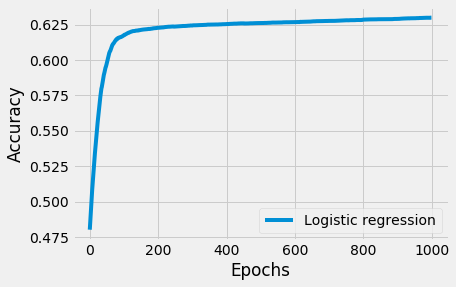

In [94]:
plt.style.use('fivethirtyeight')
plt.plot(history_log.history['acc'], label = 'Logistic regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

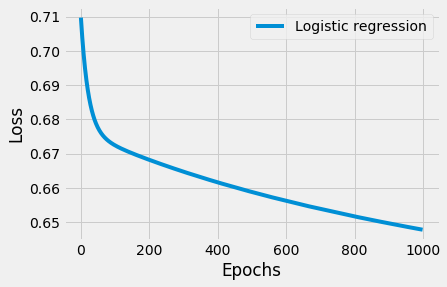

In [95]:
plt.plot(history_log.history['loss'], label='Logistic regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
model.evaluate(x=X_test,y=y_test)

31164/31164 [==============================] - 1s 24us/step


[0.647643410881039, 0.6272301373417792]

In [98]:
X_train.shape

(72714, 159)

In [100]:
X_test.shape

(31164, 159)

In [103]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(32,activation='tanh',input_dim=159))

# Second hidden layer
model.add(Dense(16,activation='tanh'))

# Output layer
model.add(Dense(1,activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train
history_tanh = model.fit(X_train, y_train, # Train on training set
                         epochs=10, # We will train over 1,000 epochs
                         batch_size=X_train.shape[0], # Batch size = training set size
                         verbose=0)

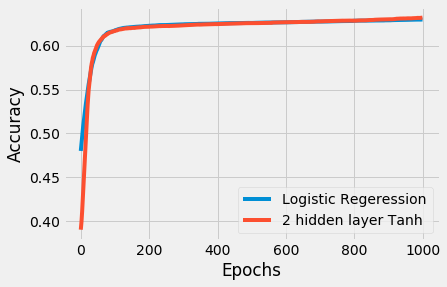

In [105]:
plt.plot(history_log.history['acc'], label= 'Logistic Regeression')
plt.plot(history_tanh.history['acc'], label= '2 hidden layer Tanh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [110]:
history_log.history['acc']

[0.4800863564014435,
 0.4842533767223358,
 0.4880628287792206,
 0.49229860305786133,
 0.4969194233417511,
 0.5007839202880859,
 0.5041257739067078,
 0.5081552267074585,
 0.5114696025848389,
 0.515224039554596,
 0.5181395411491394,
 0.5221690535545349,
 0.5257584452629089,
 0.5288665294647217,
 0.5313557386398315,
 0.5340374708175659,
 0.5368567109107971,
 0.5399647951126099,
 0.5433891415596008,
 0.5456308126449585,
 0.5486838817596436,
 0.551379382610321,
 0.5532084703445435,
 0.555972695350647,
 0.5583106279373169,
 0.5610198974609375,
 0.5630689859390259,
 0.5651869177818298,
 0.5676761269569397,
 0.5698352456092834,
 0.5725032091140747,
 0.5743048191070557,
 0.5762301683425903,
 0.5779217481613159,
 0.5798470973968506,
 0.5807134509086609,
 0.5820199847221375,
 0.58354651927948,
 0.5849354863166809,
 0.5864207744598389,
 0.5880573391914368,
 0.589322566986084,
 0.5902302265167236,
 0.5912753939628601,
 0.592430591583252,
 0.5935995578765869,
 0.5946035385131836,
 0.5951536297798157

In [106]:
model.evaluate(x=X_test,y=y_test)

31164/31164 [==============================] - 1s 23us/step


[0.6394844172457158, 0.6304389680285706]

In [114]:
from keras import regularizers
from keras.optimizers import adam


In [115]:
# Sequential model
model = Sequential()

# First hidden layer now regularized
model.add(Dense(32,activation='relu',
                input_dim=159,
                kernel_regularizer = regularizers.l2(0.01)))

# Second hidden layer now regularized
model.add(Dense(16,activation='relu',
                   kernel_regularizer = regularizers.l2(0.01)))

# Output layer stayed sigmoid
model.add(Dense(1,activation='sigmoid'))

# Setup adam optimizer
adam_optimizer=adam(lr=0.1,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Train
history_regularized=model.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=X_train.shape[0], # Batch size = training set size
                             verbose=0) 

In [118]:
history_regularized.history['acc']

[0.5775366425514221,
 0.6251341104507446,
 0.6251341104507446,
 0.4128090739250183,
 0.5731770992279053,
 0.6250515580177307,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6251341104507446,
 0.6666253805160522,
 0.6281183958053589,
 0.6327254772186279,
 0.6716725826263428,
 0.6661303043365479,
 0.6292873620

In [119]:
model.evaluate(x=X_test,y=y_test)

31164/31164 [==============================] - 1s 26us/step


[0.6063099493495063, 0.6845398536620191]

In [ ]:
fina